In [1]:
import detectron2
import os
import shutil
import torch
import cv2
import random
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.evaluation import COCOEvaluator
from detectron2.data import DatasetCatalog, MetadataCatalog, DatasetMapper
from detectron2.data import transforms as T
from detectron2.data.datasets import register_coco_instances
from detectron2.data import build_detection_train_loader
from matplotlib import pyplot as plt

%matplotlib inline
setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
os.makedirs("images", exist_ok=True)
if  len(os.listdir("images")) == 0:
    !curl -L "https://universe.roboflow.com/ds/4tQNhO3ScX?key=vzphVaMKf7" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip;
    shutil.move("test", "images/test")
    shutil.move("train", "images/train")
    shutil.move("valid", "images/valid")

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device.type)
!nvcc --version

Using PyTorch version: 2.6.0  Device: cuda
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Wed_Jan_15_19:20:09_PST_2025
Cuda compilation tools, release 12.8, V12.8.61
Build cuda_12.8.r12.8/compiler.35404655_0


In [4]:
register_coco_instances("trashnet_train", {}, "images/train/_annotations.coco.json", "images/train")
register_coco_instances("trashnet_test", {}, "images/test/_annotations.coco.json", "images/test")
register_coco_instances("trashnet_valid", {}, "images/valid/_annotations.coco.json", "images/valid")

In [5]:
train_meta = MetadataCatalog.get("trashnet_train")
train_dict = DatasetCatalog.get("trashnet_train")

WARNING [05/03 11:09:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 11:09:15 d2.data.datasets.coco]: Loaded 1757 images in COCO format from images/train/_annotations.coco.json


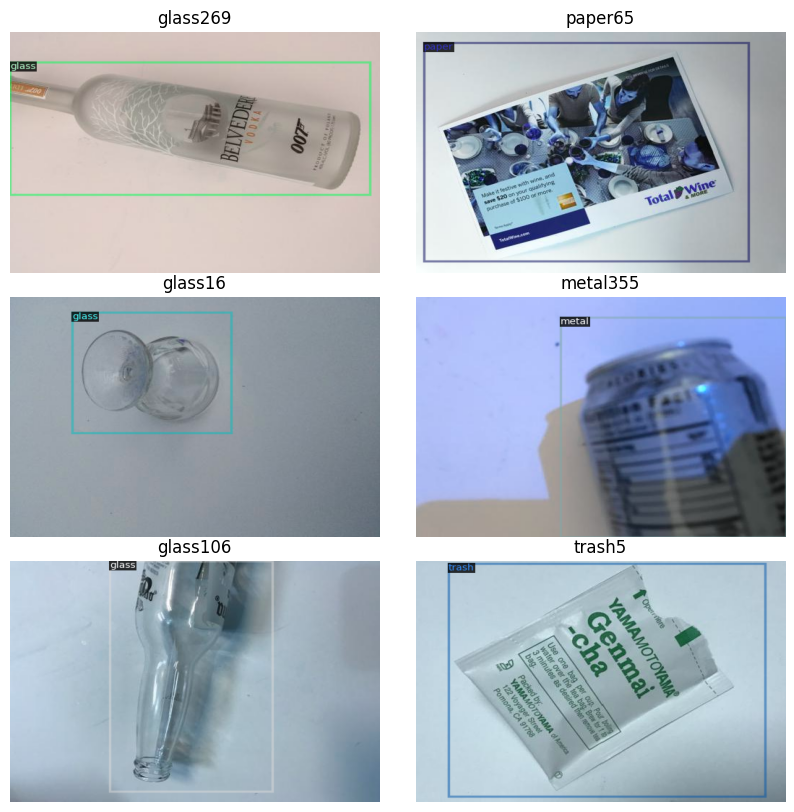

In [42]:
objects = random.sample(train_dict, 6)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
i = 0
for obj in objects:
    img = cv2.imread(obj["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_meta)
    vis = visualizer.draw_dataset_dict(obj)

    row = i // 2
    col = i % 2
    axes[row, col].axis("off")
    axes[row, col].imshow(vis.get_image()[:, :, ::-1], aspect="auto")
    axes[row, col].set_title(obj["file_name"].split("_jpg")[0].split("/")[-1])
    i += 1

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [52]:
augs = [
    T.RandomRotation([-15, 15]),
    T.RandomBrightness(0.9, 1.1),
    T.RandomContrast(0.9, 1.1),
    T.RandomSaturation(0.9, 1.1),
    T.RandomLighting(0.1),
    T.RandomFlip(0.5),
    T.RandomFlip(0.5, horizontal=False, vertical=True),
]

class COCOTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)
    @classmethod
    def build_train_loader(cls, cfg):
        train_mapper = DatasetMapper(
            cfg,
            is_train=True,
            augmentations=augs
        )
        return build_detection_train_loader(
            cfg,
            mapper=train_mapper
        )

labels = MetadataCatalog.get("trashnet_test").get("thing_classes", None)
labels

['idk', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("trashnet_train",)
cfg.DATASETS.TEST = ("trashnet_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 8000
cfg.MODEL.DEVICE = device.type
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(labels)

In [9]:
#ONLY if you want training!
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = COCOTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[05/03 11:09:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/home/bogdan/.conda/envs/detectron_env/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1744247799952/work/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/03 11:09:20 d2.utils.events]:  eta: 0:08:37  iter: 5019  total_loss: 0.06093  loss_cls: 0.02689  loss_box_reg: 0.02861  loss_rpn_cls: 1.79e-05  loss_rpn_loc: 0.001768    time: 0.1720  last_time: 0.1529  data_time: 0.0053  last_data_time: 0.0018   lr: 0.001  max_mem: 1465M
[05/03 11:09:24 d2.utils.events]:  eta: 0:08:33  iter: 5039  total_loss: 0.05473  loss_cls: 0.01706  loss_box_reg: 0.03362  loss_rpn_cls: 1.888e-05  loss_rpn_loc: 0.001488    time: 0.1706  last_time: 0.1734  data_time: 0.0021  last_data_time: 0.0014   lr: 0.001  max_mem: 1469M
[05/03 11:09:27 d2.utils.events]:  eta: 0:08:30  iter: 5059  total_loss: 0.0522  loss_cls: 0.01815  loss_box_reg: 0.02604  loss_rpn_cls: 1.31e-05  loss_rpn_loc: 0.001506    time: 0.1719  last_time: 0.1732  data_time: 0.0025  last_data_time: 0.0042   lr: 0.001  max_mem: 1469M
[05/03 11:09:31 d2.utils.events]:  eta: 0:08:32  iter: 5079  total_loss: 0.0594  loss_cls: 0.02136  loss_box_reg: 0.03612  loss_rpn_cls: 7.386e-06  loss_rpn_loc: 0.00175

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("trashnet_test", )
predictor = DefaultPredictor(cfg)

[05/03 11:17:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


WARNING [05/03 11:18:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 11:18:54 d2.data.datasets.coco]: Loaded 264 images in COCO format from images/test/_annotations.coco.json


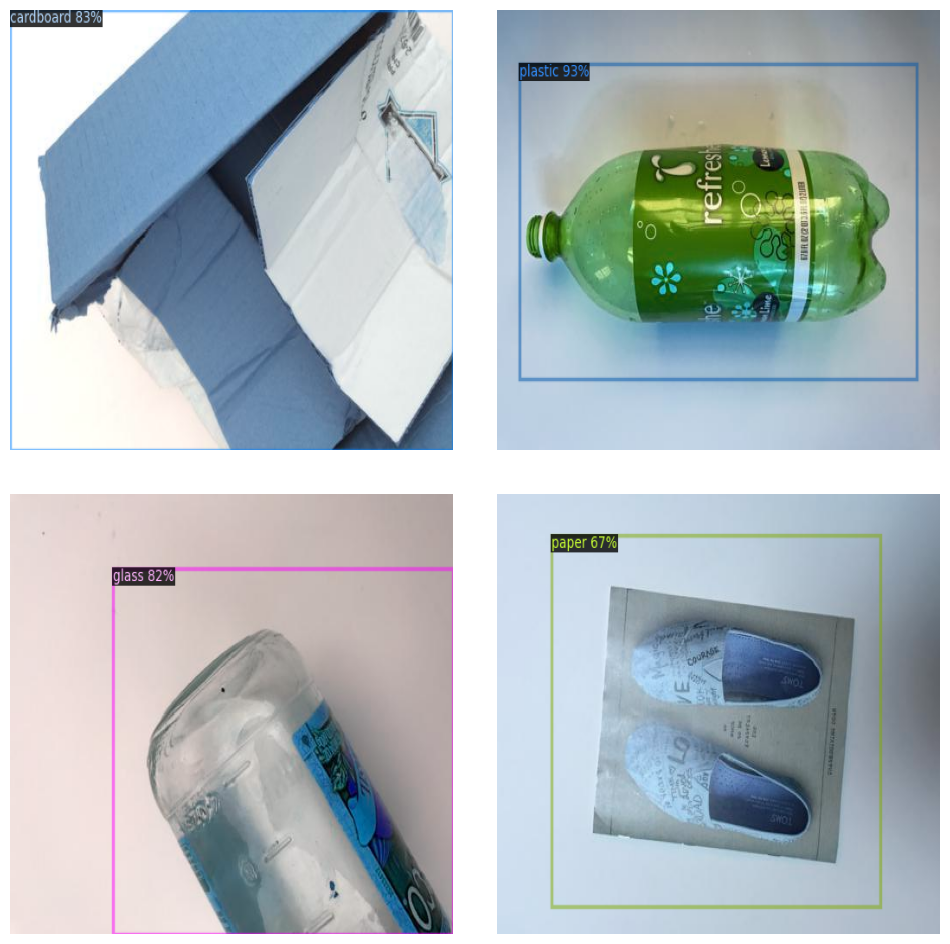

In [25]:
test_metadata = MetadataCatalog.get("trashnet_test")
test_dict = DatasetCatalog.get("trashnet_test")

objects = random.sample(test_dict, 4)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
i = 0

for obj in objects:
    img = cv2.imread(obj["file_name"])
    output = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=test_metadata)
    out = v.draw_instance_predictions(output["instances"].to("cpu"))

    row = i // 2
    col = i % 2
    axes[row, col].axis("off")
    axes[row, col].imshow(out.get_image()[:,:,::-1], aspect="auto")
    i += 1

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [43]:
%load_ext tensorboard
%tensorboard --logdir=output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 8114), started 10:27:22 ago. (Use '!kill 8114' to kill it.)

Instances(num_instances=1, image_height=1000, image_width=1000, fields=[pred_boxes: Boxes(tensor([[  0.0000,  58.8912, 987.6004, 967.0374]])), scores: tensor([0.9746]), pred_classes: tensor([1])])


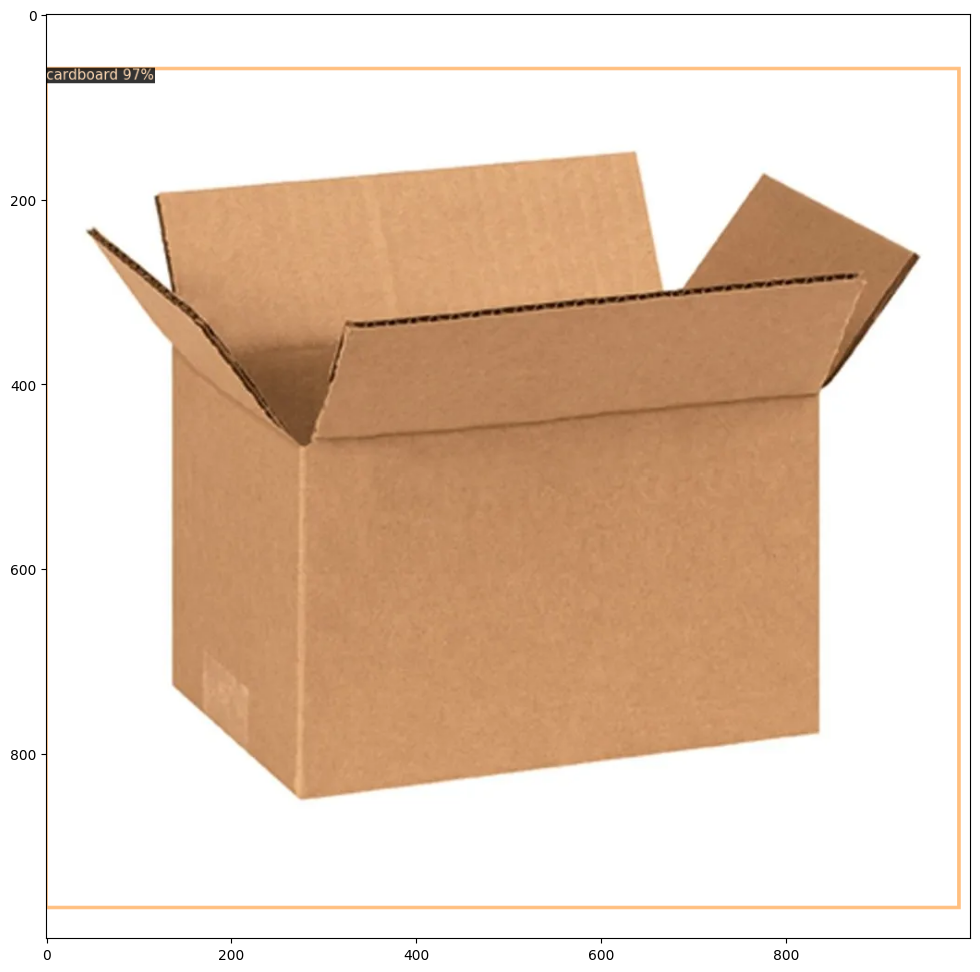

In [47]:
#image outside of the testing set

def take_and_test(image) -> None:
    output=predictor(image)
    print(output["instances"].to("cpu"))
    v = Visualizer(image[:, :, ::-1], metadata=test_metadata)
    print(v)
    v = v.draw_instance_predictions(output["instances"].to("cpu"))
    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(v.get_image()[:,:,::-1], cv2.COLOR_BGR2RGB))

test = cv2.imread("custom_test_images/box.png")
take_and_test(test)

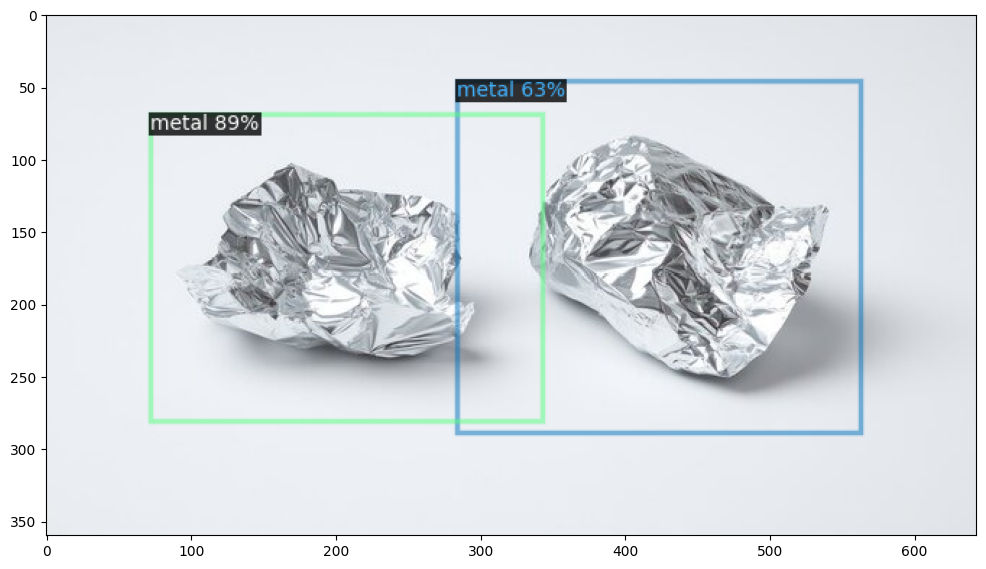

In [31]:
test = cv2.imread("custom_test_images/aluminium_foil.jpg")
take_and_test(test)

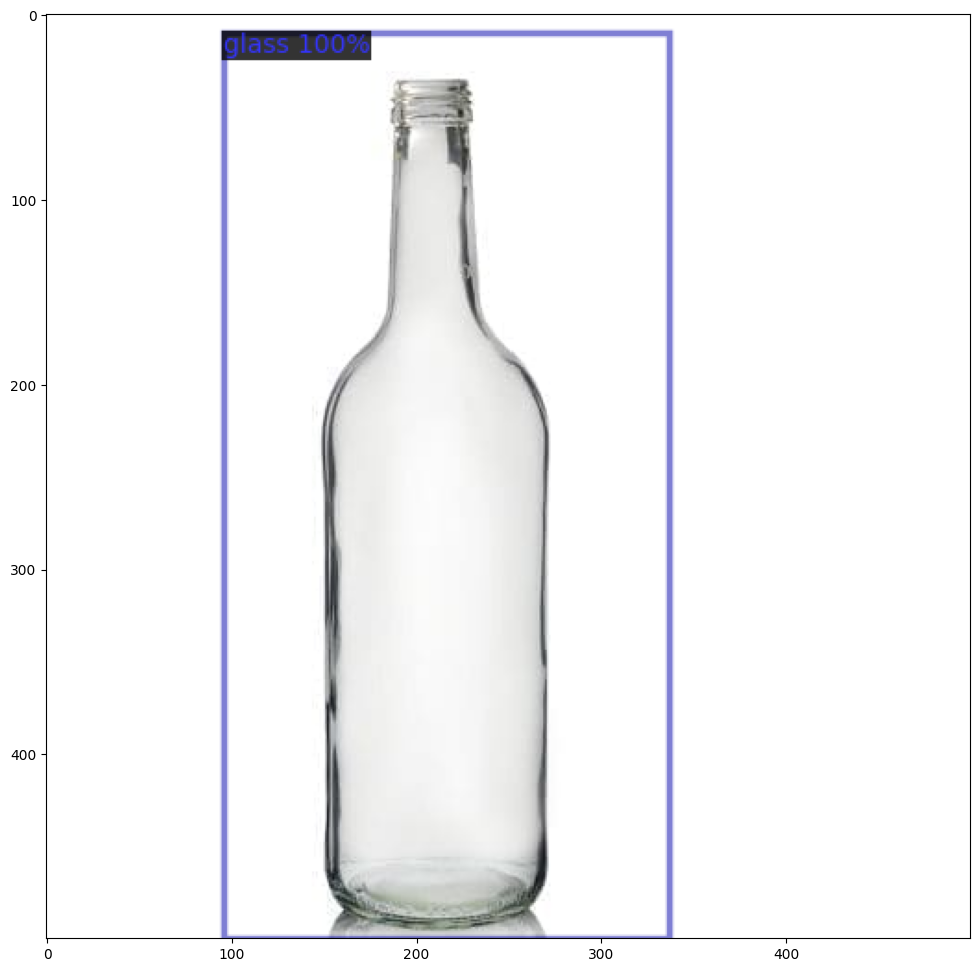

In [36]:
test = cv2.imread("custom_test_images/glass.jpg")
take_and_test(test)

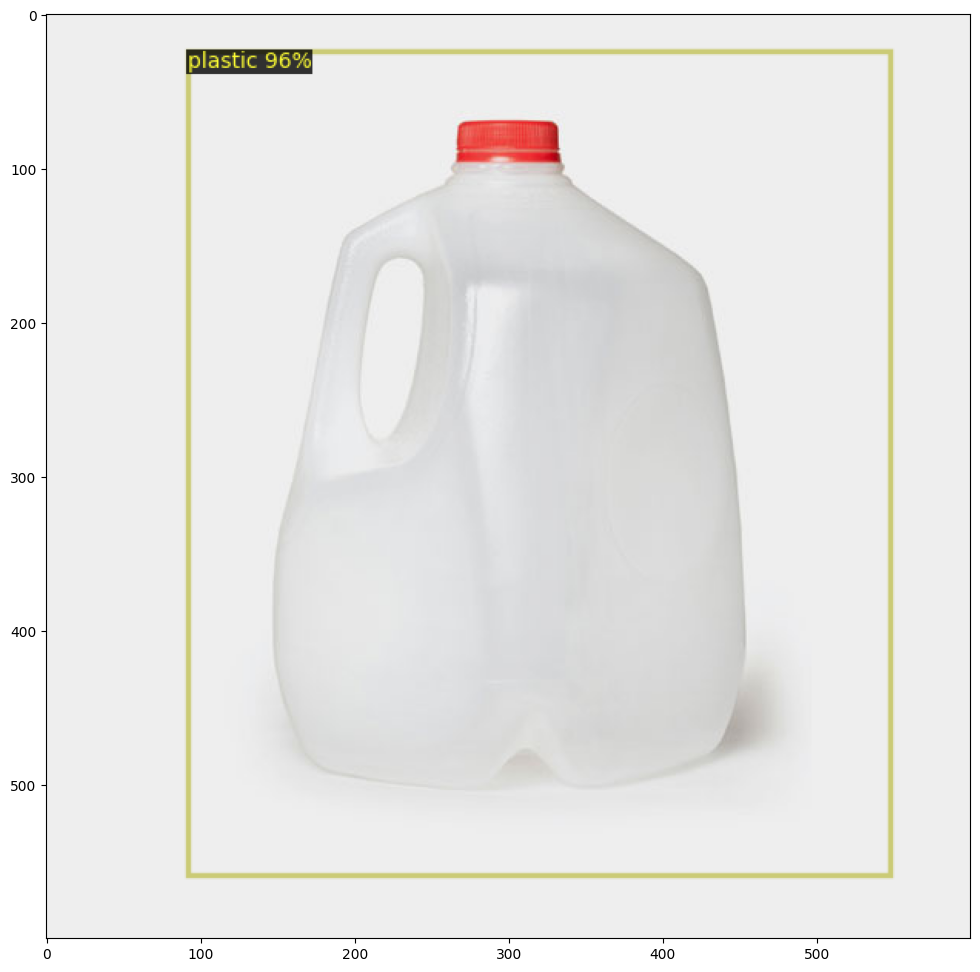

In [38]:
test = cv2.imread("custom_test_images/milk-jug-empty.jpg")
take_and_test(test)

Instances(num_instances=13, image_height=959, image_width=1370, fields=[pred_boxes: Boxes(tensor([[ 981.1414,  165.4653, 1224.7732,  512.8039],
        [1171.5880,  133.2640, 1322.3790,  496.9839],
        [ 447.2749,  147.0841,  924.0242,  550.0899],
        [ 858.5164,  147.4260, 1305.1442,  528.0178],
        [  51.0433,  457.8434,  772.1411,  917.2518],
        [ 833.8002,  622.9323, 1282.8864,  898.6774],
        [ 438.8685,  516.0123,  753.8279,  904.7003],
        [ 142.3315,  199.5268,  567.4191,  539.0426],
        [ 674.8742,  603.0100,  834.6101,  904.9536],
        [1100.4813,  615.7917, 1335.0825,  897.3113],
        [ 840.6041,  183.9976, 1073.7667,  488.8674],
        [ 981.2341,  656.5211, 1233.8092,  888.8083],
        [ 585.4547,  544.1106,  881.8155,  908.7817]])), scores: tensor([0.9700, 0.9184, 0.8687, 0.8347, 0.8118, 0.8066, 0.7852, 0.6517, 0.6451,
        0.6131, 0.5495, 0.5288, 0.5228]), pred_classes: tensor([2, 2, 1, 2, 3, 5, 5, 4, 5, 5, 2, 5, 5])])


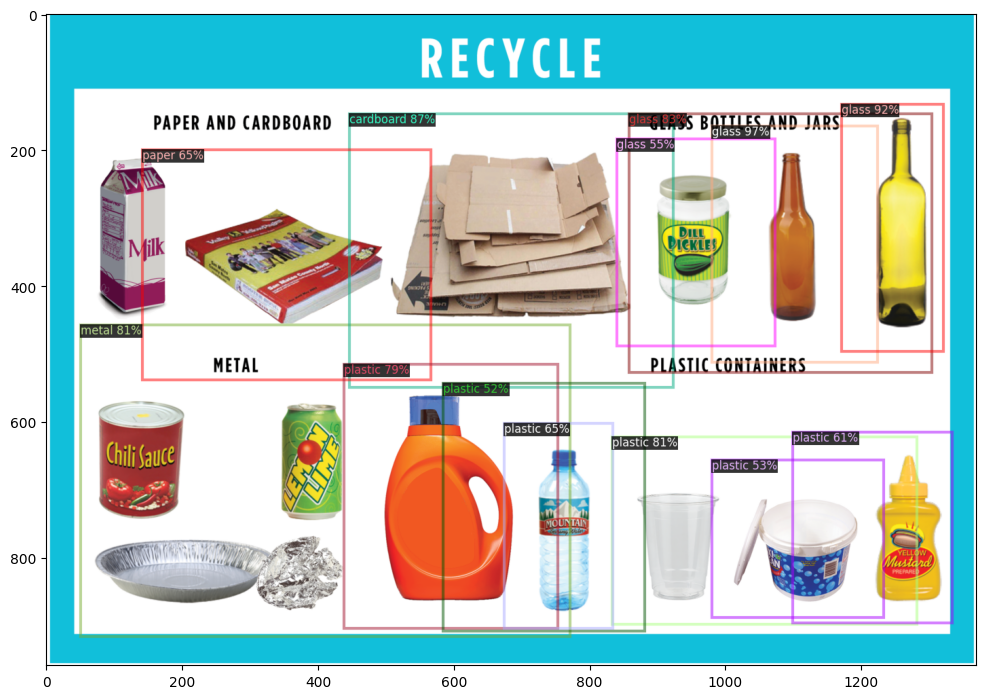

In [45]:
test = cv2.imread("custom_test_images/many.png")
take_and_test(test)

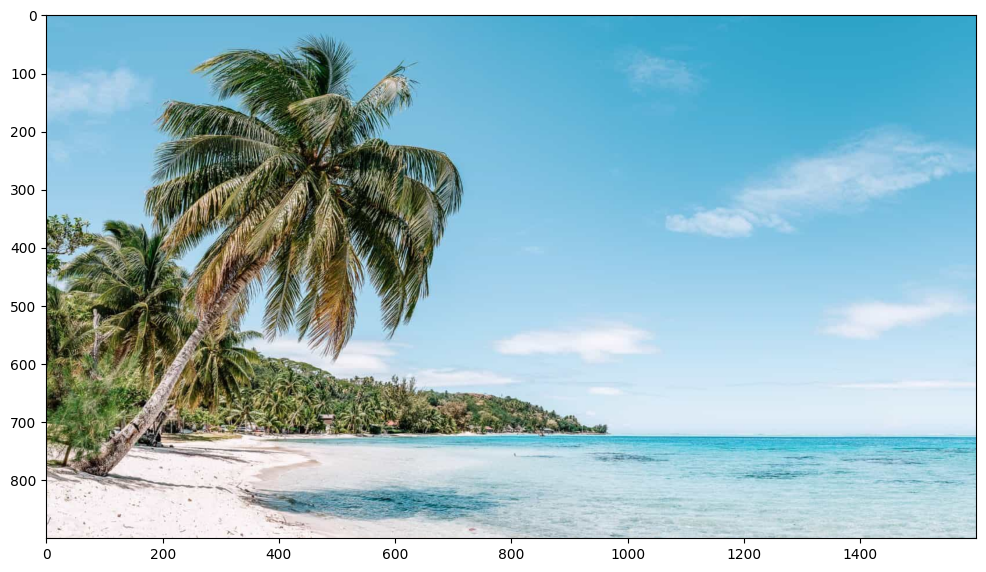

In [41]:
test = cv2.imread("custom_test_images/beach.jpg")
take_and_test(test)

In [51]:
# now save the configs to a file in order to use them on the app!
# .pth files saved the weights, which is most useful! but we need the whole configuration

with open("output/configuration.yaml", "w") as f:
    f.write(cfg.dump())